# Loi de Zipf et pré-traitements de textes

Contenu du notebook :
* Premier contact avec méthodes de Scrapping
* Introduction aux expressions régulières et aux opérations de pré-traitements du texte
* Validation empirique de la loi de Zipf et sensibilisation à la distribution statistique des corpus

In [2]:
!pip install --upgrade beautifulsoup4

     |████████████████████████████████| 115 kB 843 kB/s eta 0:00:01


In [3]:
from bs4 import BeautifulSoup          # Python parsing library
from collections import Counter
import nltk                            # NLP library
nltk.download('gutenberg')           # Run at first use
from nltk.corpus import gutenberg      
from nltk.probability import FreqDist  
import os 
import re                              # Regular Expression (Regex) in Python
import requests
import sys

# IPython automatically reload all changed code
%load_ext autoreload
%autoreload 2

# Inline Figures with matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'

[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/antoine/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [39]:
# !git clone https://github.com/AntoineSimoulin/m2-data-sciences.git
sys.path.append('/Users/antoine/Documents/Formation/m2-data-sciences/src')
from plots import plot_word_counter, plot_zipf

In [23]:
tp_dir = "./"

## Littrerature française

On cherche à s'assurer de la validité de la loi de Zipf en français. Pour cela on va construire un corpus avec des romans de la littérature française. Dans la démonstration, on propose d'utiliser des romans de Victor Hugo et Marcel Proust mais vous pouvez choisir les auteurs de votre choix.

On va récupérer les livres sur le site https://www.gutenberg.org/. Un projet qui rassemble des livres libres de droit. On récupère les tomes des Misérables et de A la recherche du temps perdu.

In [5]:
book_links = [
    # A la recherche du temps perdu
    'https://www.gutenberg.org/files/2650/2650-h/2650-h.htm',     # Du côté de chez Swann
    'https://www.gutenberg.org/files/2998/2998-h/2998-h.htm',     # À l'ombre des jeunes filles en fleurs Partie 1
    'https://www.gutenberg.org/files/2999/2999-h/2999-h.htm',     # À l'ombre des jeunes filles en fleurs Partie 2
    'https://www.gutenberg.org/files/3000/3000-h/3000-h.htm',     # À l'ombre des jeunes filles en fleurs Partie 3
    'https://www.gutenberg.org/files/8946/8946-h/8946-h.htm',     # Le Côté de Guermantes Partie 1
    'https://www.gutenberg.org/files/12999/12999-h/12999-h.htm',  # Le Côté de Guermantes Partie 2
    'https://www.gutenberg.org/files/13743/13743-h/13743-h.htm',  # Le Côté de Guermantes Partie 3
    'https://www.gutenberg.org/files/15288/15288-h/15288-h.htm',  # Sodome et Gomorrhe Partie 1
    'https://www.gutenberg.org/files/15075/15075-h/15075-h.htm',  # Sodome et Gomorrhe Partie 2
    'https://www.gutenberg.org/files/60720/60720-h/60720-h.htm',  # La Prisonnière 
    # Les misérables
    'https://www.ebooksgratuits.com/html/hugo_les_miserables_fantine.html',
    'https://www.ebooksgratuits.com/html/hugo_les_miserables_cosette.html',
    'https://www.ebooksgratuits.com/html/hugo_les_miserables_marius.html',
    'https://www.ebooksgratuits.com/html/hugo_les_miserables_idylle_plumet_epopee_st_denis.html',
    'https://www.ebooksgratuits.com/html/hugo_les_miserables_idylle_plumet_epopee_st_denis.html',
    'https://www.ebooksgratuits.com/html/hugo_les_miserables_jean_valjean.html'
]

On récupère le texte au format HTML à l'aide de la librairie Beautiful Soup. La page HTML est organisée en paragraphes qui suivent le découpage du livre.

Attention, le scrapping n'est pas toujours autorisé, il est toujours primordial de s'assurer des licences et disposition légales concernant les données que l'on cherche à récupérer.

In [6]:
%%time

paragraphes_all = []

for link in book_links:
  page = requests.get(link) 
  soup = BeautifulSoup(page.content, 'html.parser')
      
  paragraphes = soup.select('p', class_='MsoNormal', style='')
  paragraphes = [p.get_text(strip=True) for p in paragraphes]
  paragraphes = [' '.join(p.split()) for p in paragraphes]
  paragraphes_all.extend(paragraphes)

CPU times: user 3.55 s, sys: 137 ms, total: 3.69 s
Wall time: 47.4 s


In [7]:
print("Downloaded {:,d} books for a total of {:,d} paragraphs.".format(len(book_links), len(paragraphes_all)))

Downloaded 16 books for a total of 22,690 paragraphs.


In [8]:
print(paragraphes_all[0])

Longtemps, je me suis couché de bonne heure. Parfois, à peine ma bougie éteinte, mes yeux se fermaient si vite que je n'avais pas le temps de me dire: «Je m'endors.» Et, une demi-heure après, la pensée qu'il était temps de chercher le sommeil m'éveillait; je voulais poser le volume que je croyais avoir encore dans les mains et souffler ma lumière; je n'avais pas cessé en dormant de faire des réflexions sur ce que je venais de lire, mais ces réflexions avaient pris un tour un peu particulier; il me semblait que j'étais moi-même ce dont parlait l'ouvrage: une église, un quatuor, la rivalité de François Ieret de Charles Quint. Cette croyance survivait pendant quelques secondes à mon réveil; elle ne choquait pas ma raison mais pesait comme des écailles sur mes yeux et les empêchait de se rendre compte que le bougeoir n'était plus allumé. Puis elle commençait à me devenir inintelligible, comme après la métempsycose les pensées d'une existence antérieure; le sujet du livre se détachait de mo

<hr>

## Pré-traitements : les expressions régulières

Chaque paragraphe est consitué d'un unique bloc de texte. En NLP, les corpus sont généralement séparés en phrases et enregistrés dans un fichier ou on retrouve une phrase par ligne.

Les expressions régulières sont un outil très puissant. Elles permetent de rechercher des informations sous une forme standardisée. Dans l'exemple suivant, on peut cherche à extraire les numéros de téléphones. On cherche donc une suite de 10 chiffres avec éventuellement des séparateurs entre les chiffres. On peut également chercher les dates, les adresses, les montants, températures ou tout autre motif. 

In [9]:
sample_text = """
    Bonjour mon numéro de téléphone est le 04.56.55.33.66
    Super le mien est 0392020302
    Génial, je vous donne également mon tel : 03-02-02-12-89 et celui du bureau : +33 (0) 5 33 19 33 09
    Est-ce que vous seriez disponible pour un rendez vous le 06/12/20 vers 13h ?
    Les tickets coutent 13€95.
"""

Les regex permettent de chercher des motifs dans le texte. Ces motifs sont décrits par des expressions standardisées très spécifiques. En python, on peut utiliser les regex à l'aide de la librairie `re`

Par exemple, on peut chercher un chiffre dans le texte:

In [10]:
digit_pattern = re.compile('\d')

digits = re.findall(digit_pattern, sample_text)
print(digits)

['0', '4', '5', '6', '5', '5', '3', '3', '6', '6', '0', '3', '9', '2', '0', '2', '0', '3', '0', '2', '0', '3', '0', '2', '0', '2', '1', '2', '8', '9', '3', '3', '0', '5', '3', '3', '1', '9', '3', '3', '0', '9', '0', '6', '1', '2', '2', '0', '1', '3', '1', '3', '9', '5']


On peut également chercher l'ensemble des motifs ou l'on retrouve deux chiffres qui se suivent

In [11]:
digit_pattern = re.compile('\d{2}')

digits = re.findall(digit_pattern, sample_text)
print(digits)

['04', '56', '55', '33', '66', '03', '92', '02', '03', '02', '03', '02', '02', '12', '89', '33', '33', '19', '33', '09', '06', '12', '20', '13', '13', '95']


Finalement on peut chercher l'ensemble des motifs ou on retrouve plusieurs chiffres qui se suivent

In [12]:
digit_pattern = re.compile('\d+')
# + pour capter si le motif apparait entre 1 et une infinité de fois
# * pour capter si le motif apparait entre 0 et une infinité de fois

digits = re.findall(digit_pattern, sample_text)
print(digits)

['04', '56', '55', '33', '66', '0392020302', '03', '02', '02', '12', '89', '33', '0', '5', '33', '19', '33', '09', '06', '12', '20', '13', '13', '95']


On peut également chercher des groupes plus complexes, par exemple un numéro de téléphone

In [13]:
telephone_pattern = re.compile('[\d\.\-\(\) +]{5,}')
# [] est l'équivalent de "ou" pour l'ensemble des motifs de la liste
# {5,} est un quantifier plus précis que * ou +. 
# Ici, on cherche ce motif au moins 5 fois. 
# {,5} serait au maximum 5 et {5} exactement 5 fois

telephone = re.findall(telephone_pattern, sample_text)
print(telephone)

[' 04.56.55.33.66', ' 0392020302', ' 03-02-02-12-89 ', ' +33 (0) 5 33 19 33 09']


La librairie `re` comprend d'autres méthodes que `re.search`. Par exemple la fonction de substitution `re.sub` qui permet de remplacer le motif par un autre. Un exemple ici poour procéder à une dé-anonymisation des données.

In [14]:
sample_text_anonymized = re.sub(telephone_pattern, ' XX.XX.XX.XX.XX ', sample_text)
print(sample_text_anonymized)


    Bonjour mon numéro de téléphone est le XX.XX.XX.XX.XX 
    Super le mien est XX.XX.XX.XX.XX 
    Génial, je vous donne également mon tel : XX.XX.XX.XX.XX et celui du bureau : XX.XX.XX.XX.XX 
    Est-ce que vous seriez disponible pour un rendez vous le 06/12/20 vers 13h ?
    Les tickets coutent 13€95.



On pourra s'appuyer sur l'outil : https://regex101.com/. Un autre excellent site pour s'entrainer aux expresions régulières : https://alf.nu/RegexGolf et une cheat sheet : https://cheatography.com/davechild/cheat-sheets/regular-expressions/


<hr>

**Exercice 1.** Séparer les paragraphes en phrases.

In [15]:
def split_into_sentences(text):
    #TODO à compléter
    
    return sentences

In [16]:
# %load solutions/split_sentences.py
import re

sentences_pattern = re.compile(r"(?<![A-Z]\.)(?<=\.|\?|\!|»)\s", flags=re.M)

def split_into_sentences(text):
    sentences = re.split(sentences_pattern, text)
    return sentences

print('A la recherche du temps perdu')
print('-' * len('A la recherche du temps perdu'), '\n')
    
for s in split_into_sentences(paragraphes_all[0]):
    print(s, '\n')
    
# Pour la première phrase des Misérables 
miserables_first_sentence = "En 1815, M. Charles-François-Bienvenu Myriel était évêque de Digne. C’était un vieillard d’environ soixante-quinze ans ; il occupait le siège de Digne depuis 1806. Quoique ce détail ne touche en aucune manière au fond même de ce que nous avons à raconter, il n’est peut-être pas inutile, ne fût-ce que pour être exact en tout, d’indiquer ici les bruits et les propos qui avaient couru sur son compte au moment où il était arrivé dans le diocèse. "

print('Les misérables')
print('-' * len('Les misérables'), '\n')

for s in split_into_sentences(miserables_first_sentence):
    print(s, '\n')

A la recherche du temps perdu
----------------------------- 

Longtemps, je me suis couché de bonne heure. 

Parfois, à peine ma bougie éteinte, mes yeux se fermaient si vite que je n'avais pas le temps de me dire: «Je m'endors.» 

Et, une demi-heure après, la pensée qu'il était temps de chercher le sommeil m'éveillait; je voulais poser le volume que je croyais avoir encore dans les mains et souffler ma lumière; je n'avais pas cessé en dormant de faire des réflexions sur ce que je venais de lire, mais ces réflexions avaient pris un tour un peu particulier; il me semblait que j'étais moi-même ce dont parlait l'ouvrage: une église, un quatuor, la rivalité de François Ieret de Charles Quint. 

Cette croyance survivait pendant quelques secondes à mon réveil; elle ne choquait pas ma raison mais pesait comme des écailles sur mes yeux et les empêchait de se rendre compte que le bougeoir n'était plus allumé. 

Puis elle commençait à me devenir inintelligible, comme après la métempsycose les pe

<hr>

In [17]:
bookcorpus = []

for p in paragraphes_all:
    sentences = split_into_sentences(p)
    bookcorpus.extend(sentences)
    
print("Extracted {:,d} sentences".format(len(bookcorpus)))

Extracted 92,755 sentences


In [24]:
# save corpus
with open(os.path.join(tp_dir, 'data', 'miserables_temps_perdu.txt'), 'w') as f:
    for s in bookcorpus:
        f.write(s + '\n')
        
print("Saved corpus.")

Saved corpus.


In [25]:
!cat $tp_dir/data/miserables.txt | wc -l

cat: .//data/miserables.txt: No such file or directory
       0


In [26]:
# load corpus
with open(os.path.join(tp_dir, 'data', 'miserables_temps_perdu.txt'), 'r') as f:
    sentences = f.readlines()
    
sentences = [l.strip() for l in sentences if l]

On va maintenant séparer le corpus en tokens.

<hr>

**Exercice 2.** Effectuer la tokenization du corpus et créer le dictionnaire de vocabulaire

In [27]:
def tokenize(txt):
    
    #TODO à compléter
    
    return tokens

In [28]:
# %load solutions/tokenize.py
token_pattern = re.compile(r"(?:[a-zA-ZÀ-ÖØ-ö0-9])+'?")

def tokenize(text):
    tokens = re.findall(token_pattern, text)
    tokens = [t for t in tokens]
    return tokens

<hr>

In [29]:
tokenized_corpus = [tokenize(s) for s in sentences]

In [30]:
n_tokens = sum([len(t) for t in tokenized_corpus])
print("Corpus contains {:,d} tokens.".format(n_tokens))

Corpus contains 2,126,289 tokens.


In [31]:
tokenized_corpus[0]

['Longtemps', 'je', 'me', 'suis', 'couché', 'de', 'bonne', 'heure']

In [32]:
tokenized_corpus_flatten = [ll for l in tokenized_corpus for ll in l]

In [33]:
assert len(tokenized_corpus_flatten) == n_tokens

In [34]:
tokens_counter = Counter(tokenized_corpus_flatten)

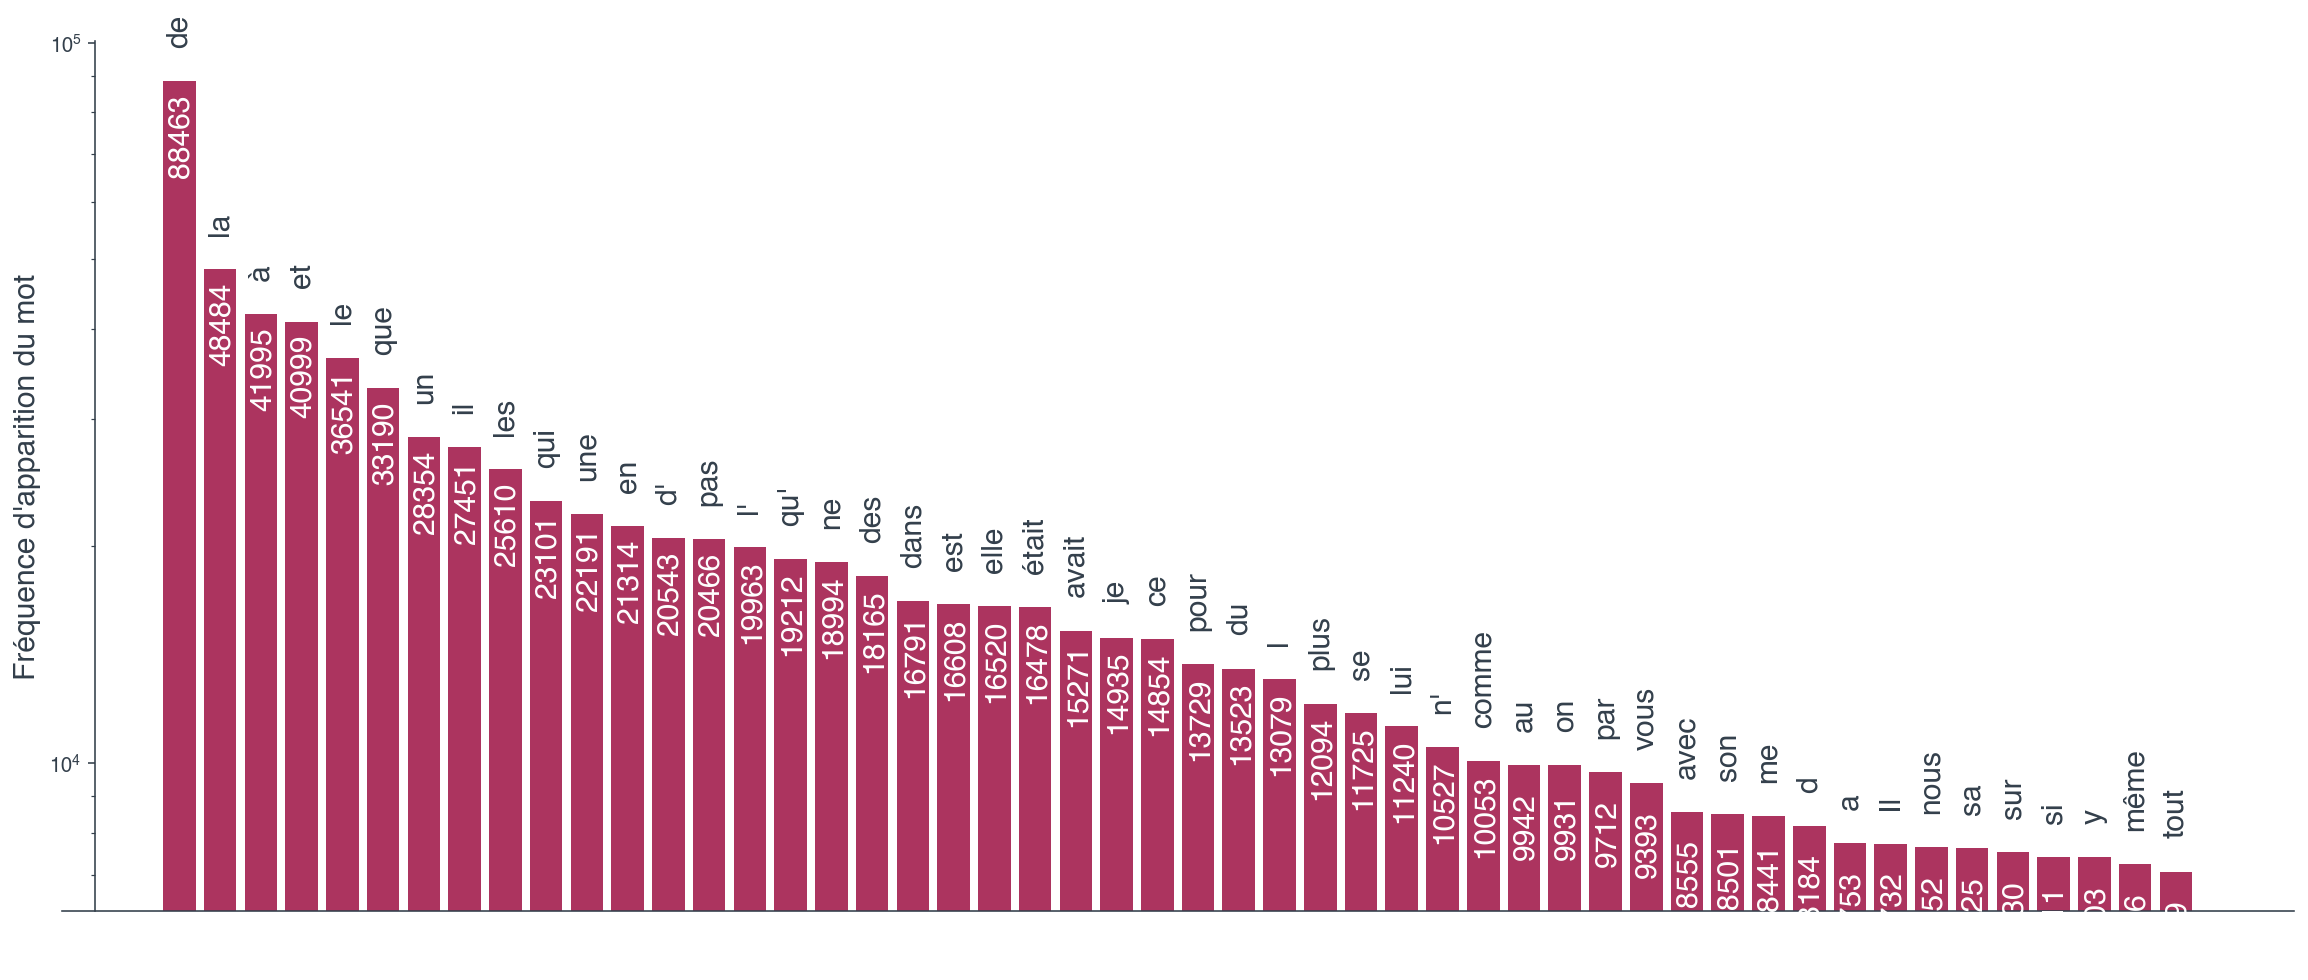

In [40]:
plot_word_counter(tokens_counter, 50)

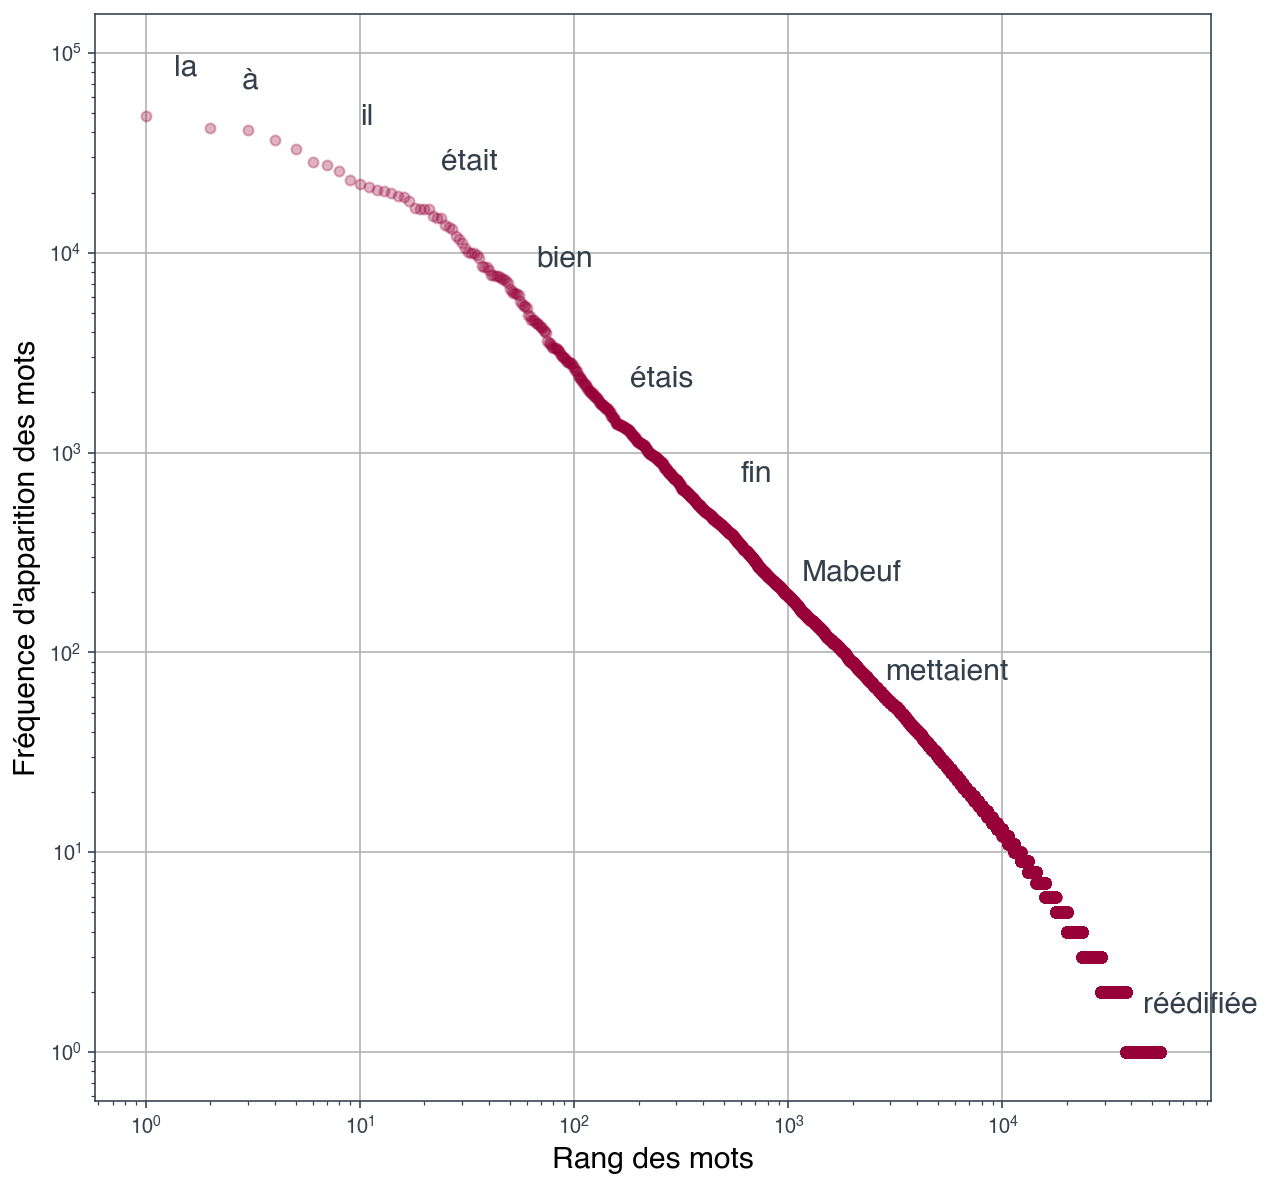

In [41]:
plot_zipf(tokens_counter)

# Jul

On compare la distribution des mots avec un autre auteur français : le rappeur [Jul](https://fr.wikipedia.org/wiki/Jul_(chanteur)) pour s'assurer que l'on retrouve une forme de distribution similaire. Les fréquences de mots ont été évaluées sur 521 chansons dont les paroles ont été scrappées sur le [AZLyrics](https://www.azlyrics.com/j/jul.html). Les données ont été traitées avec le même script que précédemment. On a directement sauvegardé les fréquences d'apparitions pour l'ensemble des mots du vocabulaire

In [42]:
tokens_counter = Counter()

with open(os.path.join(tp_dir, 'data', 'jul_freqs.txt'), 'r') as f:
    for line in f:
        k, v = line.strip().split('\t')
        tokens_counter[k] = int(v)

In [43]:
tokens_counter.most_common(10)

[("j'", 10243),
 ('la', 7314),
 ('pas', 6591),
 ("J'", 6464),
 ("l'", 5342),
 ('est', 4990),
 ('les', 4933),
 ('le', 4604),
 ('de', 3988),
 ("d'", 3859)]

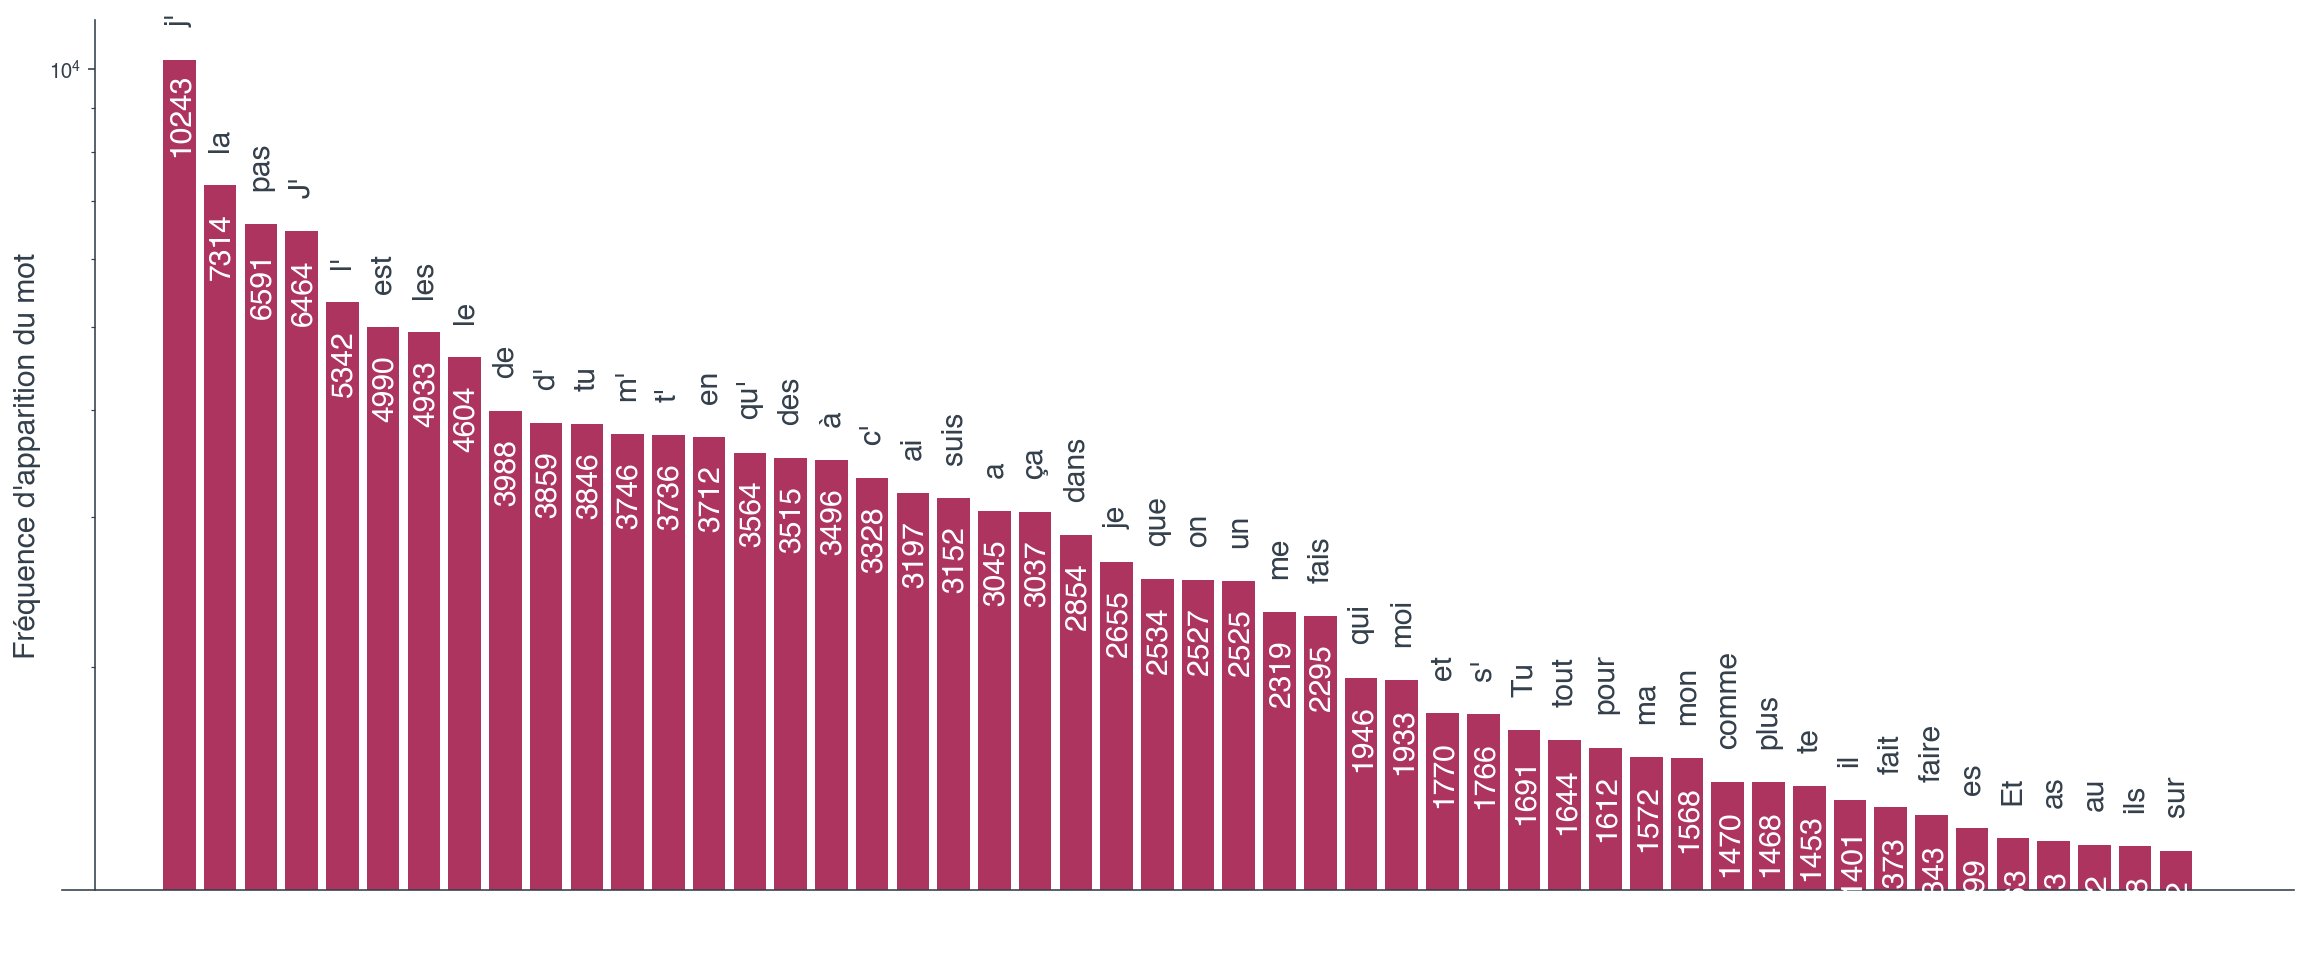

In [44]:
plot_word_counter(tokens_counter, 50)

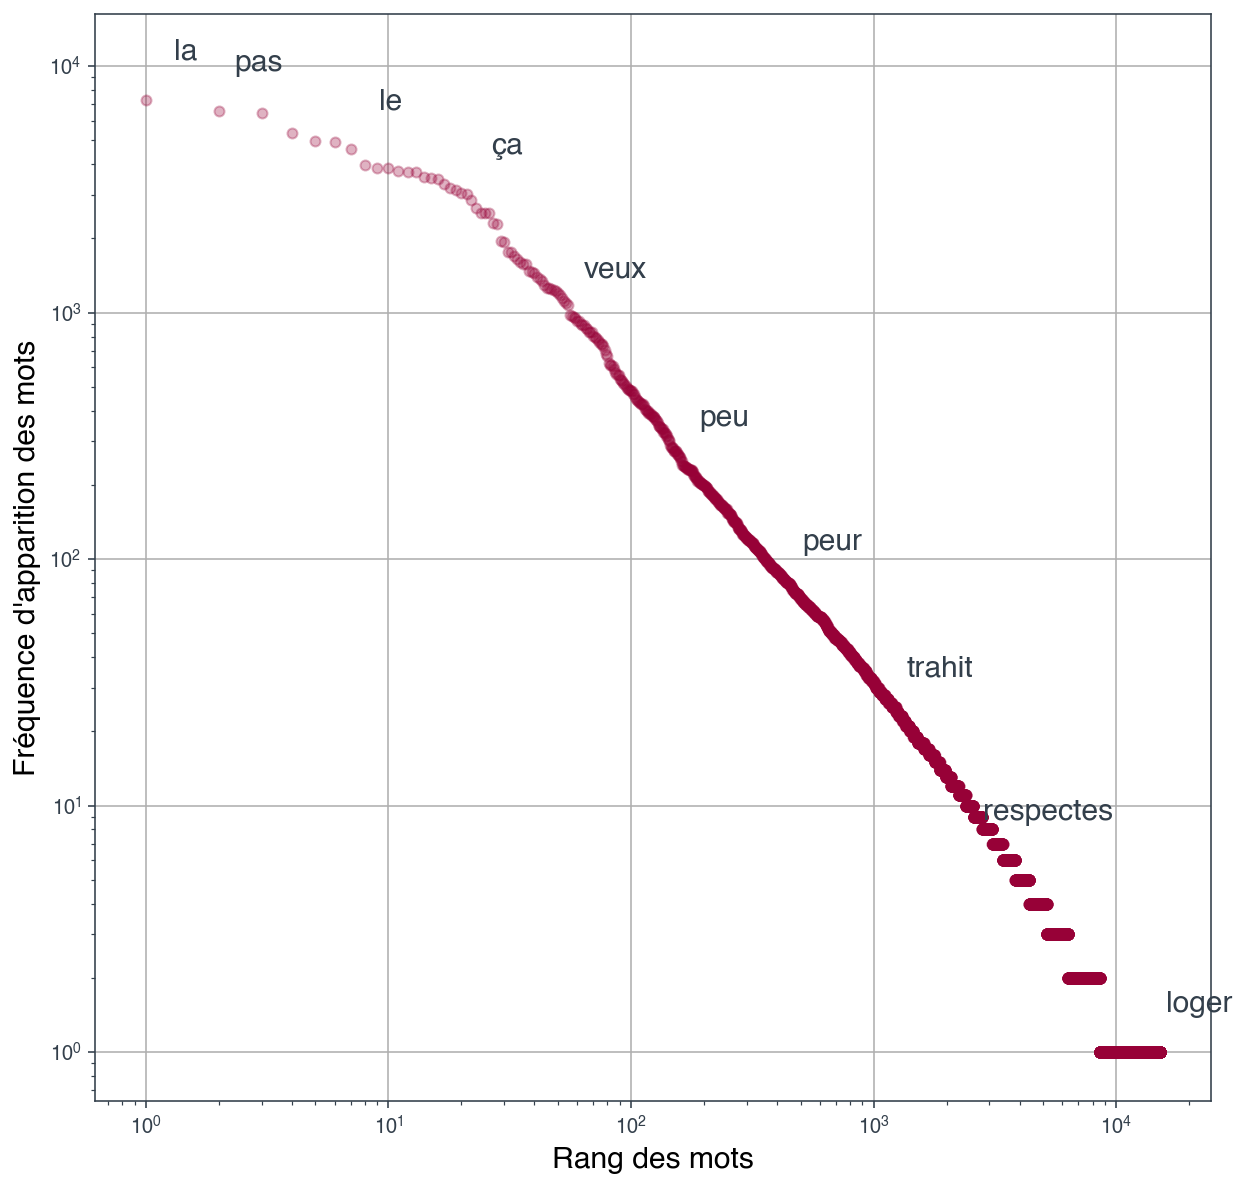

In [45]:
plot_zipf(tokens_counter)

# English Books

On compare avec la litératture anglaise en utilisant en particulier les oeuvres de Jane Austen, Shakespeare. Ces dernières sont accessibles directement en utilisant la librairie `NLTK`.

In [46]:
fd = FreqDist()
n_words = 0
for text in gutenberg.fileids():
    for word in gutenberg.words(text):
        fd[word] += 1
        n_words += 1

ranks = []
freqs = []
for rank, word in enumerate(fd):
    ranks.append(rank+1)
    freqs.append(fd[word])

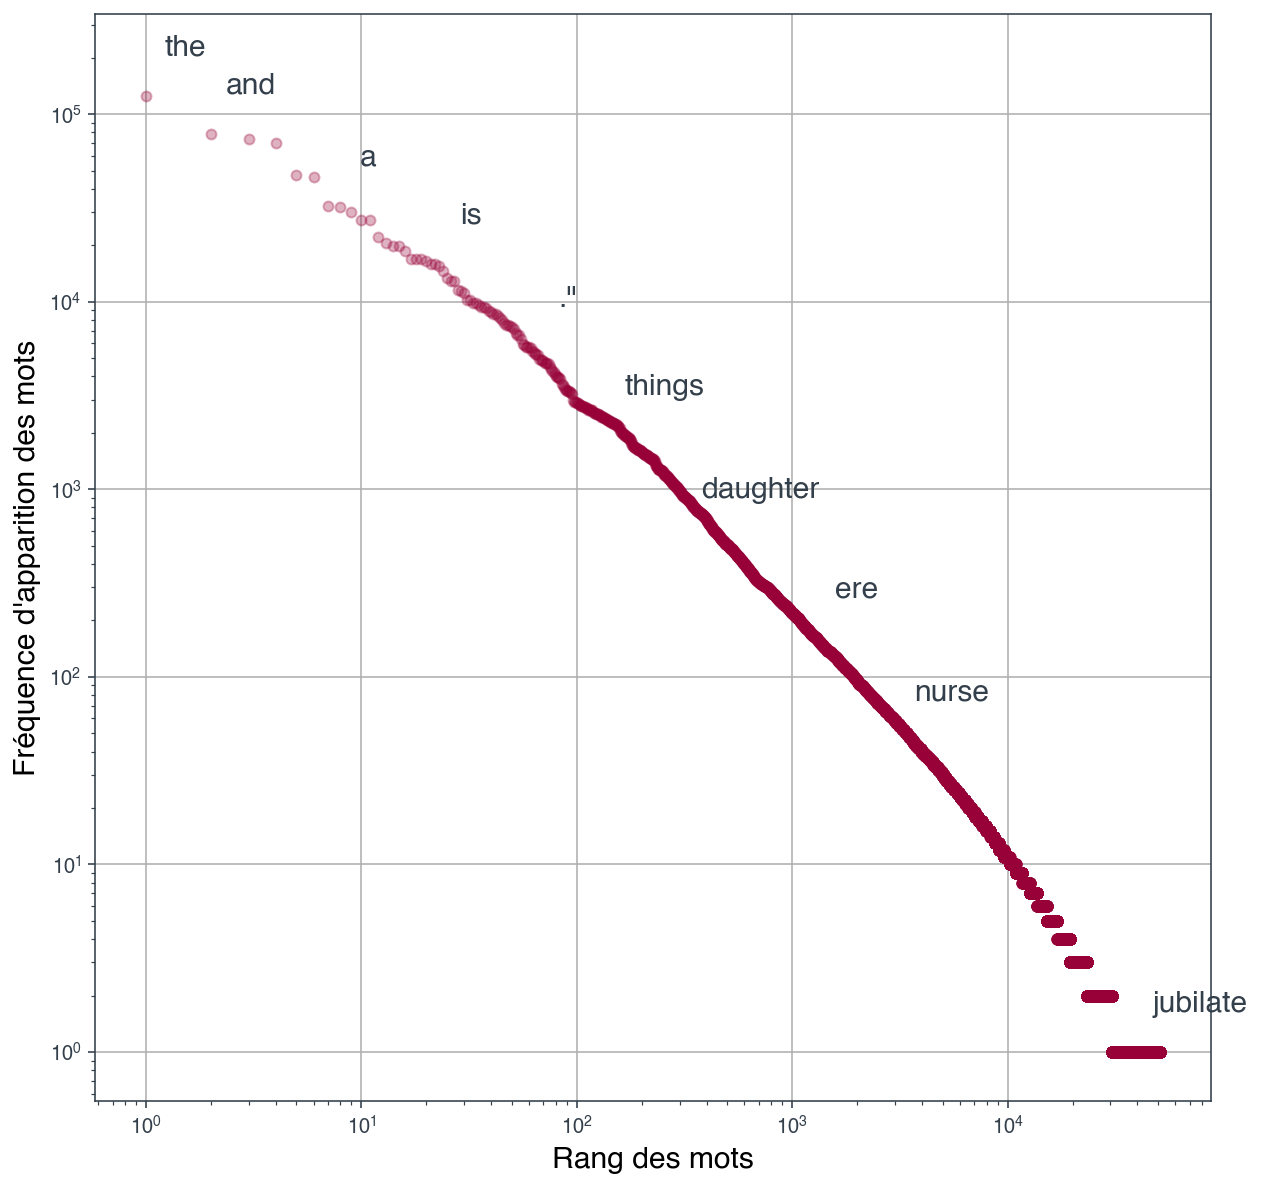

In [47]:
plot_zipf(fd)

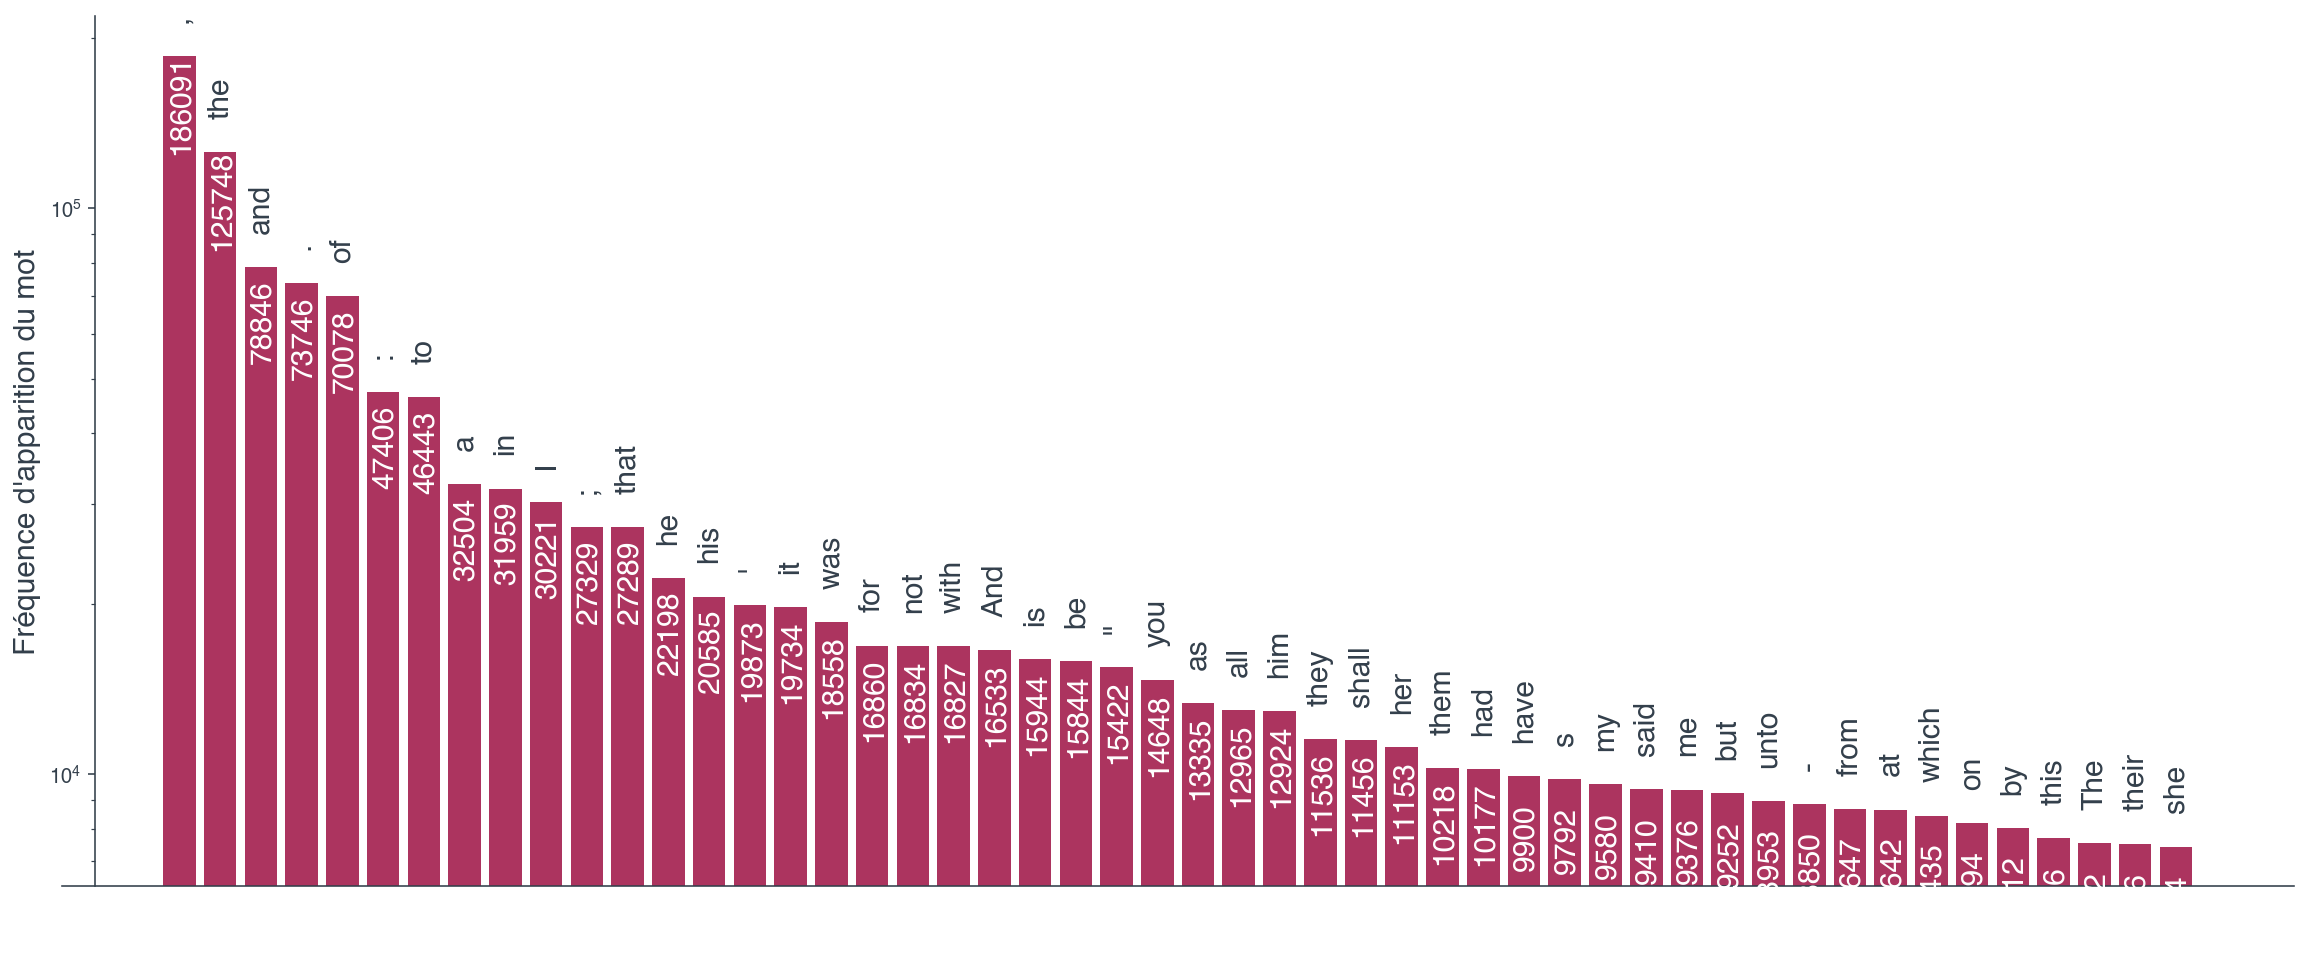

In [48]:
plot_word_counter(fd, 50)